<a href="https://colab.research.google.com/github/NataliaBilash/network_scanner/blob/master/edr_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Препроцессинг

Целью препроцессинга является первичная обработка данных, в результате которой должен получится массив содержащий обработанные значения в диапазоне от 0 до 1

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Чтобы масштабировать значения IP адреса в диапазон от 0 до 1 была создана функция scale_ip_addresses, получающая на вход IP адрес формата: доменное имя, ipv4 или ipv6, на выходе получается массив отмаштабированных значений. Получая ipv4 или ipv6 разбивает на октеты и делит на 255/65536, чтобы получились знеачения в нужном диапазоне.

In [ ]:
import ipaddress

def scale_ip_addresses(ip_address):
    try:
        ip_obj = ipaddress.ip_address(ip_address) #создает объект IP-адреса
        if ip_obj.version == 4:
            octets = ip_address.split('.')
            scaled_octets = [int(octet) / 255.0 for octet in octets]
            return scaled_octets
        elif ip_obj.version == 6:
            groups = ip_obj.exploded.split(':')
            decimal_values = [int(group, 16) for group in groups]
            scaled_values = [(value + 1) / 65536.0 for value in decimal_values]
            return scaled_values
        else:
            ip_address_domain = socket.gethostbyname(ip_address)
            octets = ip_address_domain.split('.')
            scaled_octets = [int(octet) / 255.0 for octet in octets]
            return scaled_octets
    except ValueError:
        return [0, 0, 0, 0]

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/network_data.csv')
print('Input dataframe')
print(df)

#удаление ненужных столбцов
df = df.drop(columns = ['Info', 'No.'], axis=1)

#обработка пропущенных значений
df = df.replace("Missing", pd.NA)
df = df.replace("Offln", pd.NA)
df = df.dropna()

#создание столбцов вида "Название протокола" - наличие/отсутсвие 1/0
protocol_dummies = pd.get_dummies(df['Protocol'], prefix='Protocol')
protocol_dummies = protocol_dummies.astype(int)
df_encoded = pd.concat([df, protocol_dummies], axis=1)
df_encoded.drop(['Protocol'], axis=1, inplace=True)

#применение функции scale_ip_addresses
df_encoded['Source_scaled'] = df_encoded['Source'].apply(scale_ip_addresses)
df_encoded['Destination_scaled'] = df_encoded['Destination'].apply(scale_ip_addresses)

#дополнение ipv4 до длинны 8 октетов нулями и добаление столбцоы
df_encoded['Source_scaled'] = df_encoded['Source_scaled'].apply(lambda x: x + [0] * (8 - len(x)))
df_encoded['Destination_scaled'] = df_encoded['Destination_scaled'].apply(lambda x: x + [0] * (8 - len(x)))
source_octets_df = pd.DataFrame(df_encoded['Source_scaled'].tolist(), columns=[f'Source_Octet{i}' for i in range(1, 9)])
destination_octets_df = pd.DataFrame(df_encoded['Destination_scaled'].tolist(), columns=[f'Destination_Octet{i}' for i in range(1, 9)])

#соединение датафреймов и удаление ненужных столбцов
df_encoded = pd.concat([df_encoded, source_octets_df, destination_octets_df], axis=1)
df_encoded.drop(['Source_scaled', 'Destination_scaled', 'Source', 'Destination'], axis=1, inplace=True)
df_encoded.fillna(0, inplace=True)

#нормализует значения в столбце Length и Timing_data с использованием Min-Max Scaling
scaler = MinMaxScaler()
df_encoded[['Length']] = scaler.fit_transform(df_encoded[['Length']])
df_encoded[['Timing_data']] = scaler.fit_transform(df_encoded[['Time']])

print('Output dataframe')
print(df_encoded)
print('Shape dataframe')
print(df_encoded.shape)


Input dataframe
             No.          Time       Source  Destination    Protocol  Length  \
0              1      0.000000  192.168.0.4  192.168.0.3  Modbus/TCP      78   
1              2      0.000169  192.168.0.3  192.168.0.4  Modbus/TCP      89   
2              3      0.000317  192.168.0.4  192.168.0.3         TCP      66   
3              4      0.005396  192.168.0.4  192.168.0.3  Modbus/TCP      78   
4              5      0.005528  192.168.0.3  192.168.0.4  Modbus/TCP      81   
...          ...           ...          ...          ...         ...     ...   
1100739  1100740  91719.068540  192.168.0.3  192.168.0.4  Modbus/TCP      76   
1100740  1100741  91719.068542  192.168.0.4  192.168.0.3         TCP      66   
1100741  1100742  91719.118333  192.168.0.4  192.168.0.3  Modbus/TCP      78   
1100742  1100743  91719.118637  192.168.0.3  192.168.0.4  Modbus/TCP      76   
1100743  1100744  91719.118725  192.168.0.4  192.168.0.3         TCP      66   

                       

#### Разделение на тестовые и тренировачные выборки

In [ ]:
import numpy as np

split_index = int(len(df_encoded) * 0.4)  #40% для обучения

train = df_encoded.iloc[:split_index]
test = df_encoded.iloc[split_index:]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (440297, 22)
Test dataset shape: (660447, 22)


Повторная нормализация нужна, чтобы обеспечить одинаковую шкалу значений на обеих выборках.

In [ ]:
#нормализация данных
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
print("Normalize train dataset:")
print(X_train)
print("Normalize test dataset:")
print(X_test)

Normalize train dataset:
[[0.00000000e+00 2.92682927e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.60641082e-09 5.60975610e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 4.60641082e-09]
 [8.64042739e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 8.64042739e-09]
 ...
 [9.99976277e-01 2.43902439e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 9.99976277e-01]
 [9.99976277e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 9.99976277e-01]
 [1.00000000e+00 2.92682927e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]]
Normalize test dataset:
[[1.00000001 0.56097561 0.         ... 0.         0.         1.00000001]
 [1.00000001 0.         0.         ... 0.         0.         1.00000001]
 [1.00000086 0.29268293 0.         ... 0.         0.         1.00000086]
 ...
 [2.49997597 0.29268293 0.         ... 0.         0.         2.49997597]
 [2.49997598 0.24390244 0.         ... 0.         0.  

#### Изменить форму входных данных для LSTM

Изменить форму нужно, так как на вход LSTM принимается 3D-тензор с формой (batch, timesteps, feature), где
batch: количество пакетов в наборе данных,
timesteps: количество временных шагов в пакете,
features: количество признаков в каждом временном шаге.

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (440297, 1, 22)
Test data shape: (660447, 1, 22)


## LSTM

Для модели LSTM создается начальный слой, где указывется количество временных щагов и количество признаков. Далее в кажом слое с нейронами есть функция dropout, которая помогает предотвратить переобучение, затушивая случайные нейроны в процессе обучения.

Слой RepeatVector нужен, чтобы данные восстанавливали то же измерение, что и исходные входные данные, то есть преобразование тензора функций из 1D в 2D так как для кодера-декодера входные данные сжимаются в один вектор признаков.

На выходном слое TimeDistributed применяет Dense к каждому пакету, который он получает в качестве входных данных.

In [ ]:
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(32, activation='relu', return_sequences=True, dropout=0.2)(inputs)
    L2 = LSTM(16, activation='relu', return_sequences=False, dropout=0.2)(L1)
    #повторяет последний выходной вектор
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(16, activation='relu', return_sequences=True, dropout=0.2)(L3)
    L5 = LSTM(32, activation='relu', return_sequences=True, dropout=0.2)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

Далее создается модель автоэнкодера, экперементальным путем был выделен оптимизатор Adam с заданным коэффициентом скорости обучения 0,001
loss='mae' задает функцию потерь, MAE измеряет среднее абсолютное отклонение между фактическими и предсказанными значениями, также ослеживается
метрика accuracy

In [ ]:
from keras.optimizers import Adam

model = autoencoder_model(X_train)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mae', metrics=['accuracy'])
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 22)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 1, 32)             7040      
                                                                 
 lstm_5 (LSTM)               (None, 16)                3136      
                                                                 
 repeat_vector_1 (RepeatVec  (None, 1, 16)             0         
 tor)                                                            
                                                                 
 lstm_6 (LSTM)               (None, 1, 16)             2112      
                                                                 
 lstm_7 (LSTM)               (None, 1, 32)             6272      
                                                           

In [ ]:
from keras.callbacks import ModelCheckpoint

X_val = X_test
checkpoint = ModelCheckpoint('best_model.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=1)
history1 = model.fit(X_train, X_train, epochs=50, batch_size=64, validation_data=(X_val, X_val), callbacks=[checkpoint])



Epoch 1/50
6880/6880 [==============================] - ETA: 0s - loss: 0.0573 - accuracy: 0.0868
Epoch 1: val_loss improved from inf to 0.12509, saving model to best_model.h5
6880/6880 [==============================] - 172s 24ms/step - loss: 0.0573 - accuracy: 0.0868 - val_loss: 0.1251 - val_accuracy: 0.0000e+00
Epoch 2/50
   9/6880 [..............................] - ETA: 1:27 - loss: 0.0503 - accuracy: 0.1146

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6879/6880 [============================>.] - ETA: 0s - loss: 0.0488 - accuracy: 0.0844
Epoch 2: val_loss did not improve from 0.12509
6880/6880 [==============================] - 143s 21ms/step - loss: 0.0488 - accuracy: 0.0844 - val_loss: 0.1326 - val_accuracy: 0.0000e+00
Epoch 3/50
6880/6880 [==============================] - ETA: 0s - loss: 0.0483 - accuracy: 0.0841
Epoch 3: val_loss did not improve from 0.12509
6880/6880 [==============================] - 144s 21ms/step - loss: 0.0483 - accuracy: 0.0841 - val_loss: 0.1263 - val_accuracy: 0.0000e+00
Epoch 4/50
6880/6880 [==============================] - ETA: 0s - loss: 0.0480 - accuracy: 0.0801
Epoch 4: val_loss did not improve from 0.12509
6880/6880 [==============================] - 156s 23ms/step - loss: 0.0480 - accuracy: 0.0801 - val_loss: 0.1383 - val_accuracy: 0.0000e+00
Epoch 5/50
6880/6880 [==============================] - ETA: 0s - loss: 0.0478 - accuracy: 0.0822
Epoch 5: val_loss improved from 0.12509 to 0.12299, saving

In [ ]:
from tensorflow.keras.models import load_model

LTSV_model = load_model('/content/drive/MyDrive/best_model.h5')
pred = LTSV_model.predict(X_test)


20639/20639 [==============================] - 30s 1ms/step


In [ ]:
X_test

array([[[1.00000001, 0.56097561, 0.        , ..., 0.        ,
         0.        , 1.00000001]],

       [[1.00000001, 0.        , 0.        , ..., 0.        ,
         0.        , 1.00000001]],

       [[1.00000086, 0.29268293, 0.        , ..., 0.        ,
         0.        , 1.00000086]],

       ...,

       [[2.49997597, 0.29268293, 0.        , ..., 0.        ,
         0.        , 2.49997597]],

       [[2.49997598, 0.24390244, 0.        , ..., 0.        ,
         0.        , 2.49997598]],

       [[2.49997598, 0.        , 0.        , ..., 0.        ,
         0.        , 2.49997598]]])

In [ ]:
pred

array([[[ 7.5398433e-01,  2.5590903e-01,  3.2916758e-04, ...,
         -1.2310036e-04,  2.0096451e-04,  7.5431150e-01]],

       [[ 7.5236118e-01,  2.5590551e-01,  3.3194106e-04, ...,
         -1.2429617e-04,  2.0188838e-04,  7.5268734e-01]],

       [[ 7.5348675e-01,  2.5592279e-01,  3.2962952e-04, ...,
         -1.2373365e-04,  2.0032376e-04,  7.5381184e-01]],

       ...,

       [[ 1.0333518e+00,  2.5965592e-01,  4.0713884e-04, ...,
         -4.2528100e-04,  3.0180439e-04,  1.0330997e+00]],

       [[ 1.0333116e+00,  2.5967449e-01,  4.0704478e-04, ...,
         -4.2619184e-04,  3.0246377e-04,  1.0330594e+00]],

       [[ 1.0336536e+00,  2.5951606e-01,  4.0761754e-04, ...,
         -4.1897781e-04,  2.9667094e-04,  1.0334034e+00]]], dtype=float32)

## Результаты


Выполняет оценку MAE между фактическими данными (X_test_reshaped) и предсказанными данными (pred_reshaped). Среднее абсолютное отклонение на каждом временном шаге и для каждого признака составляет приблизительно 0.1137 (ранее выбрано моделью на этапе обучения, как оптимальное val_loss).

In [ ]:
from sklearn.metrics import mean_absolute_error

#Для оценки нужно перевети в двухмерный массив
X_test_reshaped = X_test.reshape(-1, X_test.shape[2])
pred_reshaped = pred.reshape(-1, pred.shape[2])

mae = mean_absolute_error(X_test_reshaped, pred_reshaped)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 0.11356538409122476


# Тесты на данных с аномалиями

Для поиска оценки обработки аномалий были проведены следующие эксперементы. В качестстве датасета с аномалиями был применен массив данных с специально изменеными данными, сильно отличающимися от нормлаьных

In [ ]:
df_anomaly_test = pd.read_csv('/content/drive/MyDrive/anomaly_test_1.csv')

df_anomaly_test = df_anomaly_test.drop(columns = ['Info', 'No.'], axis=1)
df_anomaly_test = df_anomaly_test.replace("Missing", pd.NA)
df_anomaly_test = df_anomaly_test.replace("Offln", pd.NA)
df_anomaly_test = df_anomaly_test.dropna()

protocol_dummies = pd.get_dummies(df_anomaly_test['Protocol'], prefix='Protocol')
protocol_dummies = protocol_dummies.astype(int)

df_anomaly_test_encoded = pd.concat([df_anomaly_test, protocol_dummies], axis=1)
df_anomaly_test_encoded.drop(['Protocol'], axis=1, inplace=True)

df_anomaly_test_encoded['Source_scaled'] = df_anomaly_test_encoded['Source'].apply(scale_ip_addresses)
df_anomaly_test_encoded['Destination_scaled'] = df_anomaly_test_encoded['Destination'].apply(scale_ip_addresses)
df_anomaly_test_encoded['Source_scaled'] = df_anomaly_test_encoded['Source_scaled'].apply(lambda x: x + [0] * (8 - len(x)))
df_anomaly_test_encoded['Destination_scaled'] = df_anomaly_test_encoded['Destination_scaled'].apply(lambda x: x + [0] * (8 - len(x)))

source_octets_df_anomaly_test = pd.DataFrame(df_anomaly_test_encoded['Source_scaled'].tolist(), columns=[f'Source_Octet{i}' for i in range(1, 9)])
destination_octets_df_anomaly_test = pd.DataFrame(df_anomaly_test_encoded['Destination_scaled'].tolist(), columns=[f'Destination_Octet{i}' for i in range(1, 9)])


df_anomaly_test_encoded = pd.concat([df_anomaly_test_encoded, source_octets_df_anomaly_test, destination_octets_df_anomaly_test], axis=1)
df_anomaly_test_encoded.drop(['Source_scaled', 'Destination_scaled', 'Source', 'Destination'], axis=1, inplace=True)
df_anomaly_test_encoded.fillna(0, inplace=True)

scaler1 = MinMaxScaler()
df_anomaly_test_encoded[['Length']] = scaler.fit_transform(df_anomaly_test_encoded[['Length']])
df_anomaly_test_encoded[['Timing_data']] = scaler.fit_transform(df_anomaly_test_encoded[['Time']])

#нормализация данных
scaler2 = MinMaxScaler()
df_anomaly_test_scaled = scaler.fit_transform(df_anomaly_test_encoded)
print("Normalize dataset:")
print(df_anomaly_test_scaled)

df_anomaly_test_shaped = df_anomaly_test_scaled.reshape(df_anomaly_test_scaled.shape[0], 1, df_anomaly_test_scaled.shape[1])
print("Data shape:", df_anomaly_test_shaped.shape)

Normalize dataset:
[[0.00000000e+00 7.98934754e-03 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.84258203e-09 1.53129161e-02 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.84258203e-09]
 [3.45620416e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 3.45620416e-09]
 ...
 [9.99999996e-01 7.98934754e-03 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 9.99999996e-01]
 [9.99999999e-01 6.65778961e-03 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 9.99999999e-01]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]]
Data shape: (1100744, 1, 22)


In [ ]:
LTSV_model = load_model('/content/drive/MyDrive/best_model.h5')
pred_anomaly_test = LTSV_model.predict(df_anomaly_test_shaped)

34399/34399 [==============================] - 55s 2ms/step


## 1 метод

Нахождение аномалий происходит через прохождение порога при вычислении среднеквадратичной ошибки (MSE) между X_test и pred. Порог был поставлен для примера

In [ ]:
def mse(df_anomaly_test_shaped, pred_anomaly_test):
 df_anomaly_test_shaped, pred_anomaly_test = np.array(df_anomaly_test_shaped), np.array(pred_anomaly_test)
 return np.square(np.subtract(df_anomaly_test_shaped, pred_anomaly_test)).mean()

mse=mse(df_anomaly_test_shaped, pred_anomaly_test)
threshold = 0.07
anomalies = df_anomaly_test_shaped[mse > threshold]
print(mse)

0.08672564755217593


In [ ]:
print(anomalies) # как видно на резульат выводится полный маасив данных

[[[[0.00000000e+00 7.98934754e-03 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]]

  [[1.84258203e-09 1.53129161e-02 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 1.84258203e-09]]

  [[3.45620416e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 3.45620416e-09]]

  ...

  [[9.99999996e-01 7.98934754e-03 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 9.99999996e-01]]

  [[9.99999999e-01 6.65778961e-03 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 9.99999999e-01]]

  [[1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 1.00000000e+00]]]]


Была произведена попытка построить гисторграмму и вычислить выбросы, и в теории можно вычислить наиболее отличающиеся значения и посчитать их аномалиями.

In [ ]:
anomalies = anomalies.reshape(-1, anomalies.shape[2])
print(anomalies.shape)

(24216368, 1)


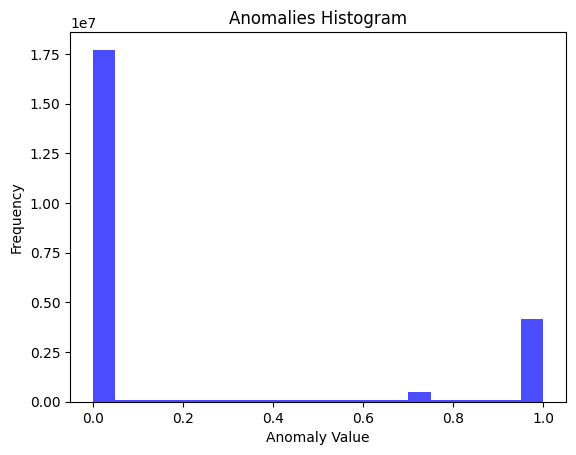

In [ ]:
import matplotlib.pyplot as plt
anomalies_values = [item[0] for item in anomalies]

#гистограмма
plt.hist(anomalies_values, bins=20, color='blue', alpha=0.7)
plt.title('Anomalies Histogram')
plt.xlabel('Anomaly Value')
plt.ylabel('Frequency')
plt.show()

## 2 Метод (Z-оценки)

Сменим подход и теперь будем вычислять разницу между предсказаными и тестовыми значениями, затем с помощью среднего значения, и вычисления z-оценок для каждого элемента подмассива найдем аномалии, тое сть наиболее отличающиеся разницы массивов X_test и diff

In [ ]:
df_anomaly_test_reshaped = df_anomaly_test_shaped.reshape(-1, df_anomaly_test_shaped.shape[2])
pred_anomaly_test_reshaped = pred_anomaly_test.reshape(-1, pred_anomaly_test.shape[2])

diff = np.abs(df_anomaly_test_reshaped - pred_anomaly_test_reshaped)
diff.shape

(1100744, 22)

In [ ]:
mean_value = sum(diff) / len(diff)

print(f"Среднее значение: {mean_value}")

Среднее значение: [1.30906708e-01 2.51135761e-01 4.08724370e-04 3.33650797e-01
 3.33327005e-01 2.31981576e-04 5.63845298e-04 5.04591037e-04
 8.37038189e-02 4.94683362e-04 2.30617003e-04 4.40257156e-04
 8.82298838e-04 7.54869909e-01 6.87677550e-04 9.05002997e-05
 7.36605566e-01 3.20063785e-04 2.97901282e-04 2.05266471e-04
 1.89837699e-04 1.30844734e-01]


In [ ]:
#Z-оценки для каждого элемента каждого подмассива
z_scores = (diff - mean_value) / np.std(diff, axis=0)

#сумма абсолютных Z-оценок для каждого подмассива
sum_z_scores = np.sum(np.abs(z_scores), axis=1)

#нахождение наиболее отличающихся, можно настроить вывод, в данном случае топ 5 отличающихся
top_indices = np.argsort(sum_z_scores)[-10:]
for index in top_indices:
    print(f"Отличающийся подмассив {index + 1}: {diff[index]}")

Отличающийся подмассив 365339: [2.15455083e-02 2.29836606e-01 9.99728056e-01 9.99652624e-01
 3.08835879e-05 1.00018596e+00 9.99765277e-01 1.00046951e+00
 9.99476314e-01 9.99567230e-01 1.00019566e+00 1.00036747e+00
 9.99228579e-01 2.44972408e-01 1.00079116e+00 1.00001138e+00
 7.50125885e-01 9.99792208e-01 1.00022346e+00 1.00016184e+00
 9.99872312e-01 2.14519886e-02]
Отличающийся подмассив 235727: [1.66186833e-02 2.29968452e-01 9.99744670e-01 9.99561667e-01
 4.31295484e-06 1.00016945e+00 9.99649644e-01 1.00046702e+00
 9.99571264e-01 9.99559981e-01 1.00015203e+00 1.00038870e+00
 9.99240752e-01 2.45034039e-01 1.00069162e+00 1.00000704e+00
 7.50057876e-01 9.99795786e-01 1.00023932e+00 1.00016657e+00
 9.99866620e-01 1.66393065e-02]
Отличающийся подмассив 538155: [7.89550271e-03 2.29765498e-01 9.99677204e-01 9.99162793e-01
 1.05686486e-04 1.00020203e+00 9.99510646e-01 1.00044591e+00
 9.99146044e-01 9.99535474e-01 1.00025199e+00 1.00039322e+00
 9.99140582e-01 2.45146036e-01 1.00056263e+00 1.00